In [ ]:
#pip install --quiet transformers==4.18.0

In [ ]:
#!pip install --quiet pytorch-lightning==1.2.7

In [ ]:
#!pip install torchtext==0.10.0

In [ ]:
from transformers import (
    AdamW,
    T5ForConditionalGeneration,
    T5TokenizerFast as T5Tokenizer
)
from tqdm.auto import tqdm

In [ ]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger

In [ ]:
import json
import pandas as pd
import numpy as np
import torch
import transformers
from pathlib import Path
from torch.utils.data import Dataset, DataLoader

#from pytorch_lightning.callbacks import ModelCheckpoint
#from pytorch_lightning.loggers import TensorBoardLogger
from sklearn.model_selection import train_test_split
from termcolor import colored
import textwrap

In [ ]:
df = pd.read_csv('../input/textsummarizationvietnamese1/Dataset_articles_NoID-1.csv', encoding = "utf-8")

In [ ]:
import pandas as pd

In [ ]:
df = df[["Summary", "Contents"]]
df.columns = ["summary", "text"]

In [ ]:
df = df.dropna()
df.head()

,summary,text
0,"Lâm Đồng - Lãnh đạo thành phố Bảo Lộc, Lâm Đồn...","Những ngày vừa qua, trên trang Facebook chính ..."
1,TPHCM - Việc không thể cưỡng chế thuế của hai ...,"Theo thông tin từ Cục Thuế TP.HCM, hiện cơ qua..."
2,"Hiện trên địa bàn tỉnh Ninh Bình có 32 khu, cụ...",CNLĐ mong muốn sớm được tiếp cận với nhà ở xã ...
3,Hoàn công nhà ở với ý nghĩa là điều kiện để đư...,Hoàn công nhà ở là một thủ tục hành chính tron...
4,Có rất nhiều lý do khiến những dự án thấp nội ...,Đi dọc đường Lê Văn Lương kéo dài xuống khu Dư...


In [ ]:
df.shape

(49371, 2)

In [ ]:
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set(style='whitegrid', palette='muted', font_scale = 1.2)
rcParams['figure.figsize'] = 16,10

In [ ]:
pl.seed_everything(42)

42

In [ ]:
train_df, test_df = train_test_split(df, test_size = 0.1)
train_df.shape, test_df.shape

((44433, 2), (4938, 2))

In [ ]:
class NewsSummaryDataset(Dataset):
 def __init__(
      self,
      data: pd.DataFrame,
      tokenizer: T5Tokenizer,
      text_max_token_len: int = 512,
      summary_max_token_len: int = 128
 ):
   self.tokenizer = tokenizer
   self.data = data
   self.text_max_token_len = text_max_token_len
   self.summary_max_token_len = summary_max_token_len
 def __len__(self):
   return len(self.data)
 def __getitem__(self, index : int):
   data_row = self.data.iloc[index]

   text = data_row["text"]
   text_encoding = tokenizer(
       text,
       max_length = self.text_max_token_len,
       padding = "max_length",
       truncation = True,
       return_attention_mask = True,
       add_special_tokens = True,
       return_tensors = "pt"
   )
   summary_encoding = tokenizer(
       data_row["summary"],
       max_length = self.summary_max_token_len,
       padding = "max_length",
       truncation = True,
       return_attention_mask = True,
       add_special_tokens = True,
       return_tensors = "pt"
   )
   labels = summary_encoding["input_ids"]
   labels[labels == 0] = -100

   return dict(
       text = text,
       summary = data_row["summary"],
       text_input_ids = text_encoding["input_ids"].flatten(),
       text_attention_mask = text_encoding["attention_mask"].flatten(),
       labels = labels.flatten(),
       labels_attention_mask = summary_encoding["attention_mask"].flatten()
   )

In [ ]:
class NewsSummaryDataModule(pl.LightningDataModule):
   def __init__(
       self,
       train_df: pd.DataFrame,
       test_df: pd.DataFrame,
       tokenizer: T5Tokenizer,
       batch_size: int = 8 ,
       text_max_token_len: int =512,
       summary_max_token_len: int = 128
   ):
       super().__init__()
       self.train_df = train_df
       self.test_df = test_df

       self.batch_size = batch_size
       self.tokenizer = tokenizer

       self.text_max_token_len = text_max_token_len
       self.summary_max_token_len = summary_max_token_len
   def setup(self, stage = None):
      self.train_dataset = NewsSummaryDataset(
          self.train_df,
          self.tokenizer,
          self.text_max_token_len,
          self.summary_max_token_len
      )
      self.test_dataset = NewsSummaryDataset(
          self.test_df,
          self.tokenizer,
          self.text_max_token_len,
          self.summary_max_token_len
      )
   def train_dataloader(self):
      return DataLoader(
          self.train_dataset,
          batch_size = self.batch_size,
          shuffle = True,
          num_workers = 2
      )
   def val_dataloader(self):
     return DataLoader(
       self.test_dataset,
       batch_size = self.batch_size,
       shuffle = True,
       num_workers = 2
     )

In [ ]:
MODEL_NAME = "t5-base"
tokenizer = T5Tokenizer.from_pretrained(MODEL_NAME)

Downloading:   0%|          | 0.00/773k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.32M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

In [ ]:
text_token_counts, summary_token_counts = [],[]

for _, row in train_df.iterrows():
  text_token_count = len(tokenizer.encode(row["text"]))
  text_token_counts.append(text_token_count)

  summary_token_count = len(tokenizer.encode(row["summary"]))
  summary_token_counts.append(summary_token_count)

Token indices sequence length is longer than the specified maximum sequence length for this model (2430 > 512). Running this sequence through the model will result in indexing errors


Text(0.5, 1.0, 'summary text token counts')

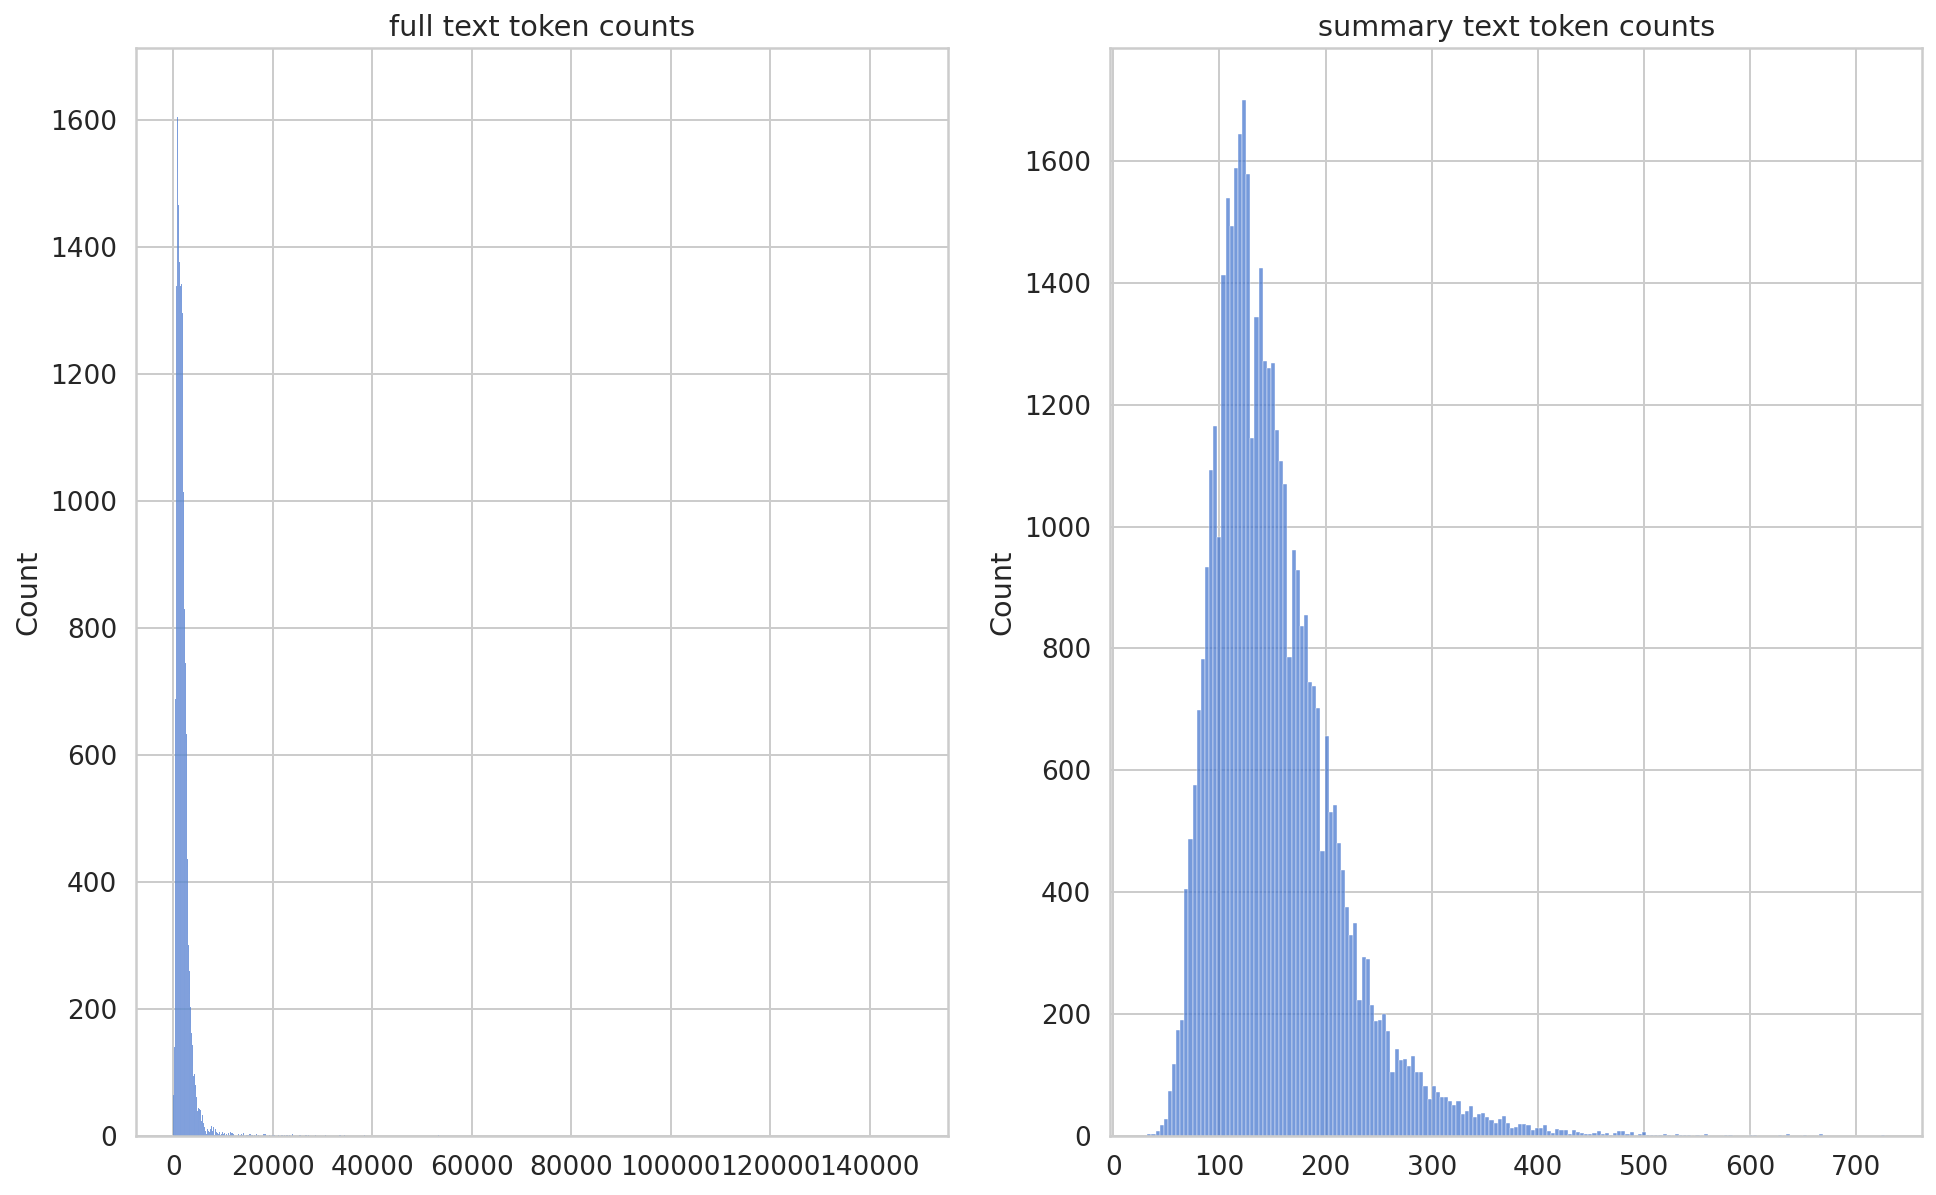

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2)

sns.histplot(text_token_counts, ax = ax1)
ax1.set_title("full text token counts")

sns.histplot(summary_token_counts, ax= ax2)
ax2.set_title("summary text token counts")

In [ ]:
num_epochs = 3
BATCH_SIZE = 8

data_module = NewsSummaryDataModule(train_df, test_df, tokenizer,batch_size = BATCH_SIZE)

In [ ]:
class NewsSummaryModel(pl.LightningModule):
   def __init__(self):
     super().__init__()
     self.model =  T5ForConditionalGeneration.from_pretrained(MODEL_NAME, return_dict = True)
   def forward(self, input_ids, attention_mask, decoder_attention_mask, labels = None):
     output = self.model(
         input_ids,
         attention_mask = attention_mask,
         labels = labels,
         decoder_attention_mask = decoder_attention_mask
     )

     return output.loss, output.logits

   def training_step(self, batch, batch_idx):
     input_ids = batch["text_input_ids"]
     attention_mask = batch["text_attention_mask"]
     labels = batch["labels"]
     labels_attention_mask = batch["labels_attention_mask"]

     loss, outputs = self(
         input_ids = input_ids,
         attention_mask = attention_mask,
         decoder_attention_mask = labels_attention_mask,
         labels = labels
     )
     self.log("train_loss", loss, prog_bar = True, logger = True)
     return loss
   def validation_step(self, batch, batch_idx):
     input_ids = batch["text_input_ids"]
     attention_mask = batch["text_attention_mask"]
     labels = batch["labels"]
     labels_attention_mask = batch["labels_attention_mask"]

     loss, outputs = self(
         input_ids = input_ids,
         attention_mask = attention_mask,
         decoder_attention_mask = labels_attention_mask,
         labels = labels
     )
     self.log("val_loss", loss, prog_bar = True, logger = True)
     return loss

   def test_step(self, batch, batch_idx):
     input_ids = batch["text_input_ids"]
     attention_mask = batch["text_attention_mask"]
     labels = batch["labels"]
     labels_attention_mask = batch["labels_attention_mask"]

     loss, outputs = self(
         input_ids = input_ids,
         attention_mask = attention_mask,
         decoder_attention_mask = labels_attention_mask,
         labels = labels
     )

     self.log("test_loss", loss, prog_bar = True, logger = True)
     return loss

   def configure_optimizers(self):
     return AdamW(self.parameters(), lr = 0.0001)

In [ ]:
model = NewsSummaryModel()

Downloading:   0%|          | 0.00/850M [00:00<?, ?B/s]

In [ ]:
%load_ext tensorboard
%tensorboard --logdir ./linghtning_logs

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [ ]:
checkpoint_callback = ModelCheckpoint(
        dirpath ="checkpoints",
        filename = "best-checkpoint",
        save_top_k=1,
        verbose=True,
        monitor='val_loss',
        mode='min'
    )
logger = TensorBoardLogger("lightning_logs", name = "news-summary")

In [ ]:
trainer = pl.Trainer(
    logger = logger ,
    checkpoint_callback = checkpoint_callback,
    max_epochs = num_epochs,
    gpus = 1,
    progress_bar_refresh_rate = 30
)

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:152: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=<pytorch_lightning.callbacks.model_checkpoint.ModelCheckpoint object at 0x78004e5bf210>)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=<pytorch_lightning.callbacks.model_checkpoint.ModelCheckpoint object at 0x78004e5bf210>)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:97: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=30)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Tr

In [ ]:
trainer.fit(model, data_module)


/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Sanity Checking: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:498: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  category=PossibleUserWarning,
/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:245: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  category=PossibleUserWarning,


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:245: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  category=PossibleUserWarning,


Training: 0it [00:00, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Validation: 0it [00:00, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py:726: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [ ]:
trained_model = NewsSummaryModel.load_from_checkpoint(
    trainer.checkpoint_callback.best_model_path
)

trained_model.freeze()

In [ ]:
def summarize(text):
  text_encoding = tokenizer(
      text,
      max_length = 512,
      padding = "max_length",
      truncation = True,
      return_attention_mask = True,
      add_special_tokens = True,
      return_tensors = "pt"
  )

  generated_ids = trained_model.model.generate(
      input_ids = text_encoding["input_ids"],
      attention_mask = text_encoding["attention_mask"],
      max_length = 150,
      num_beams = 2,
      repetition_penalty=2.5,
      length_penalty = 1.0,
      early_stopping = True
  )

  preds = [
      tokenizer.decode(gen_id, skip_special_tokens = True,clean_up_tokenization_spaces= True )
      for gen_id in generated_ids
  ]

  return "".join(preds)

In [ ]:
sample_row = test_df.iloc[0]
text = sample_row["text"]
model_summary = summarize(text)

In [ ]:
text

'Chiều 11.10, Thành ủy TPHCM phối hợp với Hội đồng Lý luận Trung ương tổ chức Hội thảo khoa học chuyên đề “Quản lý đô thị trên địa bàn TPHCM: thực trạng, vấn đề và giải pháp”. Tại hội thảo,\xa0GS.KTS Trần Ngọc Chính cho rằng, TPHCM là đô thị đặc biệt, đô thị lớn của Việt Nam, có ý nghĩa rất quan trọng đối với Khu vực Đông Nam Á và quốc tế. Vì thế, cần có giải pháp nghiên cứu để làm sao TPHCM xứng tầm là đô thị mang tầm quốc tế. Trong đó, cần gắn TPHCM vào nghiên cứu quy hoạch vùng để gắn kết với nhau rất quan trọng. Hệ thống giao thông công cộng tốt nhất để tạo cho việc đi lại của người dân thuận lợi.  Để quản lý sự phát triển của TPHCM, nhất là vấn đề giao thông, hạ tầng kinh tế, hạ tầng xã hội cần liên kết vùng, phát triển vùng TPHCM. Mở rộng không gian quy hoạch để tạo động lực cho TPHCM phát triển. Ông Trần Ngọc Chính, đề xuất 2 phương án mở rộng TPHCM. Phương án 1: Chủ yếu mở rộng về phía tỉnh Long An, lấy sông Vàm Cỏ Đông làm ranh giới tự nhiên gồm các huyện Cần Giuộc, Cần Đước v

In [ ]:
sample_row["summary"]

'Trước sự gia tăng dân số và những thách thức trong phát triển đô thị mà TPHCM đang gặp phải,\xa0GS.KTS Trần Ngọc Chính\xa0- Chủ tịch Hội Quy hoạch Phát triển đô thị Việt Nam đề xuất TPHCM nên mở rộng thêm về phía tỉnh Long An.'

In [ ]:
model_summary

'Hi tho khoa hc chuyên  “Qun l ô th trên a bàn TPHCM: thc trng, vn  và gii pháp”.'

In [ ]:
sample_row = test_df.iloc[1]
text = sample_row["text"]
model_summary = summarize(text)

In [ ]:
text

'Ngày 3.12, Tòa án nhân dân tỉnh Cà Mau\xa0tiếp tục xét xử sơ thẩm vụ ông Trần Thanh Dân - Giám đốc Công ty Cát Vàng Cà Mau - lừa đảo chiếm đoạt tài sản.\xa0 Trong phần tranh luận, đại diện Viện Kiểm sát tỉnh Cà Mau giữ quyền công tố vẫn giữ nguyên quan điểm ông Trần Thanh Dân có dấu hiệu lừa đảo 9 tỉ đồng từ hợp đồng vay vốn của BIDV Cà Mau, có bảo lãnh của Ngân hàng Phát triển Việt Nam chi nhánh Minh Hải (VDB Minh Hải) trong dự án đầu tư tại Tiền Giang. Bởi toàn bộ hồ sơ này là không có thật, các chứng từ khống, gian dối để ngân hàng BIDV Cà Mau giải ngân 9 tỉ đồng.   Có tiền, ông Dân không đầu tư mà trả nợ ngoài, không đầu tư như dự án đã được thẩm định.   Theo cáo trạng, ông Dân cùng 2 đồng phạm lừa đảo chiếm đoạt tài sản. Cụ thể số tiền chiếm đoạt của BIDV là 9 tỉ đồng, VDB Minh Hải là người có quyền lợi và nghĩa vụ liên quan.   Tuy nhiên, tại tòa ông Dân và những luật sư của ông cho rằng ông không lừa đảo; các cơ quan tố tụng đã hình sự hóa giao dịch dân sự.  Ông Dân cho rằng 

In [ ]:
sample_row["summary"]

'Bị truy tố vì lừa ngân hàng 9 tỉ đồng, ông Trần Thanh Dân, Giám đốc Cty Cát Vàng cho rằng có 9 cái đầu cũng không lừa được ngân hàng bởi, ngân hàng có một rừng thủ tục trước khi giải ngân.'

In [ ]:
model_summary

'Cà Mau - La o chim ot tài sn có du hiu la o 9 t ng t hp ng vay vn ca BIDV Cà Mau, có bo lnh ca Ngân hàng Phát trin Vit Nam chi nhánh Minh Hi.'

In [ ]:
sample_row = test_df.iloc[2]
text = sample_row["text"]
model_summary = summarize(text)

In [ ]:
text

'Chiều ngày 26.2, Cơ quan Cảnh sát điều tra Công an tỉnh An Giang ra Quyết định tạm giữ hình sự đối với Nguyễn Thị Mỹ Ngọc, sinh năm 1978 và cho gia đình bảo lãnh đối với Nguyễn Văn Dũng, sinh năm 1972, cùng trú tại thị trấn Vĩnh Thạnh Trung, huyện Châu Phú, tỉnh An Giang để điều tra về hành vi “Môi giới mại dâm”.  Trước đó, từ tin báo của quần chúng nhân dân tại nhà nghỉ Thành Lợi thuộc tổ 30, ấp Mỹ Thuận, xã Mỹ Phú (huyện Châu Phú) đang có hoạt động mại dâm, Tổ công tác thuộc Phòng Cảnh sát hình sự Công an tỉnh An Giang tiến hành kiểm tra. Qua kiểm tra, Tổ công\xa0 tác phát hiện tại phòng 309 và 310 của nhà nghỉ Thành Lợi có 02 cặp nam nữ đang có hành vi mua bán dâm. Tại Cơ quan Công an, bước đầu các đối tượng khai nhận: Sau khi được Nguyễn Thị Mỹ Ngọc và Nguyễn Văn Dũng giới thiệu gái bán dâm, giữa người bán dâm và người mua dâm thỏa thuận giá rồi Ngọc và Dũng điều gái mua dâm tới nhà nghỉ. Ngay sau đó, lực lượng Công an tiến hành mời Ngọc và Dũng về trụ sở làm việc, Ngọc và Dũng đã

In [ ]:
sample_row["summary"]

'An Giang – Công an tỉnh An Giang tạm giữ hình sự 2 đối tượng môi giới mại dâm trong nhà nghỉ.'

In [ ]:
model_summary

'Công an tnh An Giang va bt gi hnh s i vi Nguyn Th M Ngc, sinh năm 1978 và cho gia nh bo lnh i vi Nguyn Văn Dng.'

In [ ]:
sample_row = test_df.iloc[10]
text = sample_row["text"]
model_summary = summarize(text)

In [ ]:
text

'Hôm nay (23.5), Đội Cảnh sát hình sự Công an TP.Rạch Giá và Công an phường Vĩnh Thanh Vân đang tiếp tục củng cố hồ sơ để xử lý theo quy định của pháp luật đối với Lê Thanh Tâm (sinh ngày 17.2.2009, tạm trú phường Vĩnh Thanh, TP.Rạch Giá) về hành vi trộm cắp tài sản.   Tại cơ quan Công an, Tâm khai nhận, do cần tiền chơi game và tiêu xài nên vào trưa 21.5, Tâm đã đột nhập vào nhà của một người dân ở khu phố 5, phường Vĩnh Thanh Vân (TP.Rạch Giá) lấy trộm nhiều dây chuyền, đôi bông tay, nhẫn, vàng miếng (loại 24K và Bạch kim), khoảng 10 triệu đồng tiền mặt, 1.000 đô la Mỹ, 500 đô la tiền Úc (ước tính tổng giá trị tài sản khoảng 200 triệu đồng).    Tâm nhanh chân tẩu thoát ra ngoài rồi đi xe ôm về nhà trọ cất giấu vàng. Sau đó, Tâm lấy tiền, một ít vàng và đôla trong số tài sản vừa trộm được đem đến thị trấn Sóc Sơn, huyện Hòn Đất. Tâm bán vàng và đôla cho một người đàn ông được 16,2 triệu đồng đi đánh bạc và thua hết. Đến rạng sáng 22.5, Tâm đang trên đường về nhà trọ thì bị trinh sát b

In [ ]:
sample_row["summary"]

'Do cần tiền để chơi game và chơi tài xỉu, thiếu niên 12 tuổi đã đột nhập vào nhà người dân trộm tiền và vàng ở TP.Rạch Giá và huyện Hòn Đất, tỉnh Kiên Giang.'

In [ ]:
model_summary

'Công an TP.Rch Giá và Công an phng Vnh Thanh Vân ang tip tc cng c h s  x l theo quy nh ca pháp lut i vi Lê Thanh Tâm v hành vi trm cp tài sn'

In [ ]:
sample_row = test_df.iloc[53]
text = sample_row["text"]
model_summary = summarize(text)

In [ ]:
text

'Ngày 14.10, lãnh đạo Công an huyện Đắk Song, tỉnh Đắk Nông cho biết, liên tiếp đơn vị đã phối hợp với Cục Cảnh sát hình sự Bộ Công an bắt giữ 2 đối tượng truy nã về tội trồng cây cần sa trái phép và lạm dụng tín nhiệm chiếm đoạt tài sản khi đang lẩn trốn trên địa bàn TPHCM.   Theo đó, Công an huyện Đắk Song phối hợp Cục Cảnh sát hình sự Bộ Công an bắt giữ đối tượng Nguyễn Thế Hiển (SN 1984), trú tại xã Phú Túc, huyện Châu Thành, tỉnh Bến Tre khi đang lẩn trốn trên địa bàn TPHCM. Đây là đối tượng bị Cơ quan Cảnh sát điều tra Công an huyện Đắk Song ra quyết định truy nã về\xa0 tội “Trồng cây cần sa trái phép” vào ngày 16.9.2021.   Theo hồ sơ vụ án, tháng 6.2021, Nguyễn Thế Hiển thuê một số đối tượng trồng 2.613 cây cần sa tại một khu đất thuộc thôn 10, xã Nam Bình. Khi bị lực lượng Công an huyện Đắk Song phát hiện bắt quả tang, Hiển đã bỏ trốn. Quá trình điều tra, Cơ quan Công an huyện Đắk Song đã bắt, xử lý các đối tượng liên quan. Sau đó, Cơ quan Cảnh sát điều tra Công an huyện Đắk So

In [ ]:
sample_row["summary"]

'Công an huyện Đắk Song (tỉnh Đắk Nông) phối hợp với\xa0Cục Cảnh sát hình sự Bộ Công an liên tiếp bắt giữ 2 đối tượng truy nã đang lẩn trốn tại TPHCM.'

In [ ]:
model_summary

'Công an huyn k Song, tnh k Nông bt gi 2 i tng truy n v ti trng cây cn sa trái phép và lm dng tn nhim chim ot tài sn khi ang ln tr'

In [ ]:
sample_row = test_df.iloc[22]
text = sample_row["text"]
model_summary = summarize(text)

In [ ]:
text

'Theo đó, toà phúc thẩm tuyên y án sơ thẩm mức án 9 năm tù với bị cáo Yến về tội "Lợi dụng chức vụ, quyền hạn trong khi thi hành công vụ". Bị cáo Nguyễn Minh Khoa (cựu phó phòng an ninh chính trị nội bộ, Công an tỉnh Sơn La) bị tuyên y án sơ thẩm, mức án 8 năm tội "Đưa hối lộ". Bị cáo Lò Văn Huynh bị tuyên y án 21 năm tổng cộng 2 tội "Lợi dụng chức vụ quyền hạn trong khi thi hành công vụ" và "Nhận hối lộ".  Bị cáo Nguyễn Thanh Nhàn, cựu chuyên viên và Phó trưởng Phòng Khảo thí và Quản lý chất lượng giáo dục bị tuyên y án 30 tháng tội "Lợi dụng chức vụ quyền hạn trong khi thi hành công vụ". Do bị cáo Nguyễn Thị Hồng Nga, cựu chuyên viên Phòng khảo thí xin rút kháng cáo nên HĐXX không xem xét. Bị cáo Nguyễn Thị Hồng Nga bị cấp sơ thẩm phạt 19 năm 6 tháng tù tổng cộng 2 tội "Lợi dụng chức vụ quyền hạn trong khi thi hành công vụ" và "Nhận hối lộ". Cũng tại phiên phúc thẩm, toà đã bác đơn bà Lê Thị Thanh Yến (vợ bị cáo Huynh) và ông Lê Thanh Sơn (em vợ ông Huynh) - hai người có quyền lợi ng

In [ ]:
sample_row["summary"]

'Sáng 20.11, sau một ngày xét xử, TAND Cấp cao tại Hà Nội đã tuyên bố, bác kháng cáo kêu oan của cựu Phó Giám đốc Sở Giáo dục và Đào tạo Sơn La - ông Trần Xuân Yến.'

In [ ]:
model_summary

'Sn La - Toà phc thm tuyên y án s thm mc án 9 năm tù vi b cáo Yn v ti "Li dng chc v, quyn hn trong khi thi hành công v" và "Nhn hi l'

In [ ]:
sample_row = test_df.iloc[19]
text = sample_row["text"]
model_summary = summarize(text)

In [ ]:
text

'Theo đó, sáng ngày 28.2, đoàn lãnh đạo cấp cao Đảng Lao động Triều Tiên đã đi tham quan Hải Dương và Công ty Nhựa An Phát tại Hải Dương. Dẫn đầu\xa0đoàn lãnh đạo cấp cao Triều Tiên\xa0thăm Hải Dương có ông\xa0Ri Su Yong - Ủy viên Bộ Chính trị, Phó Chủ tịch Ban Chấp hành Đảng Lao động Triều Tiên. Đoàn lãnh đạo cấp cao Đảng Lao động Triều Tiên gồm có: ông Kim Pyong He - Phó Chủ tịch Đảng kiêm Trưởng ban Đảng; ông O Su Yong - Ủy biên Bộ Chính trị, Phó Chủ tịch Ban chấp hành Đảng Lao động Triều Tiên, Trưởng ban Kinh tế Trung ương; ông No Kwang Chol - Bộ trưởng các lực lượng vũ trang nhân dân; ông Park Yong Nam - Bí thư Tỉnh ủy Gangwon và các quan chức cấp cao khác. Chuyến thăm là một trong số các hoạt động bên lề của đoàn lãnh đạo Đảng Lao động Triều Tiên tham dự Hội nghị thượng đỉnh Mỹ - Triều Tiên lần 2 tại Hà Nội và chuyến thăm hữu nghị chính thức Việt Nam của Chủ tịch Triều Tiên Kim Jong-un. Trong buổi tiếp xã giao đoàn cấp cao Triều Tiên,\xa0Bí thư Tỉnh ủy Hải Dương Nguyễn Mạnh Hiển 

In [ ]:
sample_row["summary"]

'Ngày 28.2, đoàn cấp cao Đảng Lao động Triều Tiên (WPK) do ông Ri Su Yong - Ủy viên Bộ Chính trị, Phó Chủ tịch Ban Chấp hành Đảng Lao động Triều Tiên dẫn đầu thăm đã có chuyến thăm tỉnh Hải Dương và Công ty Nhựa An Phát tại Hải Dương.'

In [ ]:
model_summary

'oàn lnh o cp cao ng Lao ng Triu Tiên  i tham quan Hi Dng và Công ty Nha An Phát ti Hi Dng.'